In [1]:
import os
import time
import pathlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display

from PIL import Image

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
data_dir = tf.keras.utils.get_file(origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname = 'flower_photos', untar = True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [5]:
# Class names are file names

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['dandelion', 'roses', 'tulips', 'daisy', 'sunflowers'],
      dtype='<U10')

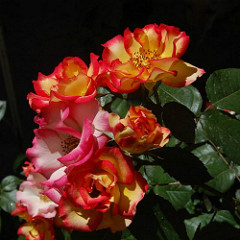

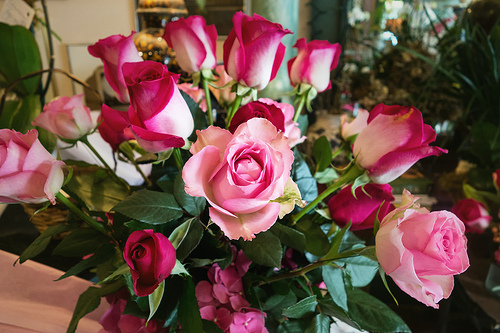

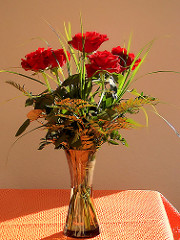

In [6]:
# Visualize dataset

roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [7]:
# Params

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [8]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize = (10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [9]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [10]:
train_data_gen = image_generator.flow_from_directory(directory = str(data_dir),
                                                     batch_size = BATCH_SIZE,
                                                     shuffle = True,
                                                     target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


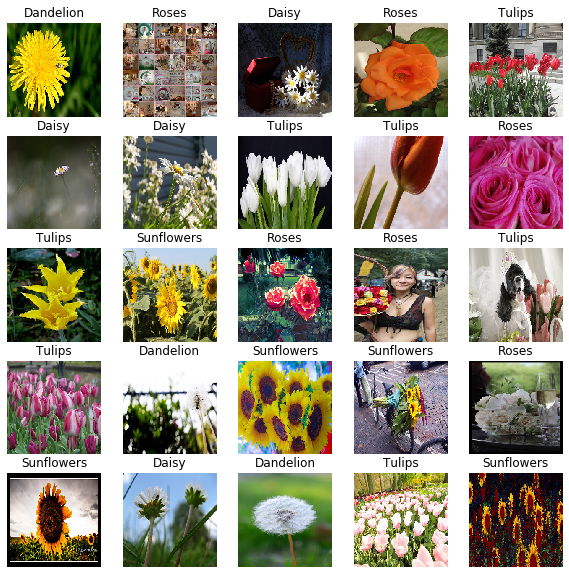

In [11]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [12]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [13]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/tanmay/.keras/datasets/flower_photos/sunflowers/5999024446_5721493894.jpg'
b'/home/tanmay/.keras/datasets/flower_photos/roses/8516036987_8a06dfe1b5_n.jpg'
b'/home/tanmay/.keras/datasets/flower_photos/tulips/18270448366_d5676dec64_z.jpg'
b'/home/tanmay/.keras/datasets/flower_photos/dandelion/7184780734_3baab127c2_m.jpg'
b'/home/tanmay/.keras/datasets/flower_photos/dandelion/19586799286_beb9d684b5.jpg'


In [14]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [15]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels = 3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [16]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [17]:
# Use Dataset.map to create a dataset of image, label pairs
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.

labeled_ds = list_ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [18]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False False False False]


In [19]:
def prepare_for_training(ds, cache = True, shuffle_buffer_size = 1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size = shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size = AUTOTUNE)

  return ds

In [20]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

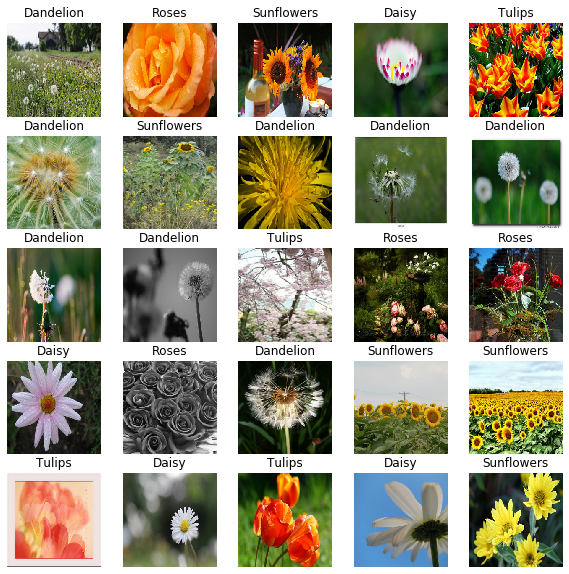

In [21]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [22]:
# Check performance 

default_timeit_steps = 1000

def timeit(ds, steps = default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.', end = '')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [23]:
# `keras.preprocessing`
timeit(train_data_gen)

....................................................................................................
1000 batches: 79.82092761993408 s
400.89737 Images/s


In [24]:
# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 5.671760559082031 s
5641.98712 Images/s


In [25]:
# Benefit of cache = True
uncached_ds = prepare_for_training(labeled_ds, cache = False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 26.234645128250122 s
1219.76112 Images/s
